In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

column_names = ['userId', 'productId', 'Rating', 'timestamp']

# Load the dataset
file_path = "ratings_Electronics (1).csv" 
sampled_data = pd.read_csv(file_path, names=column_names, header=None)

print("Dataset loaded successfully with column names!")
print(sampled_data.head())
print(f"Sampled dataset dimensions: {sampled_data.shape}")


Dataset loaded successfully with column names!
           userId   productId  Rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200
Sampled dataset dimensions: (7824482, 4)


In [2]:
print("Unique ratings:", sampled_data['Rating'].unique())

min_rating = sampled_data['Rating'].min()
max_rating = sampled_data['Rating'].max()

if max_rating > 5 or min_rating < 1:
    sampled_data['Rating'] = 1 + 4 * (sampled_data['Rating'] - min_rating) / (max_rating - min_rating)
    print("Ratings normalized to a 1-to-5 scale!")


Unique ratings: [5. 1. 3. 2. 4.]


In [3]:
Tnu = sampled_data['userId'].nunique()
Tni = sampled_data['productId'].nunique()

print(f"Total number of users (Tnu): {Tnu}")
print(f"Total number of items (Tni): {Tni}")

product_ratings_count = sampled_data.groupby('productId').size()
print("Number of ratings for each product calculated")


Total number of users (Tnu): 4201696
Total number of items (Tni): 476002
Number of ratings for each product calculated


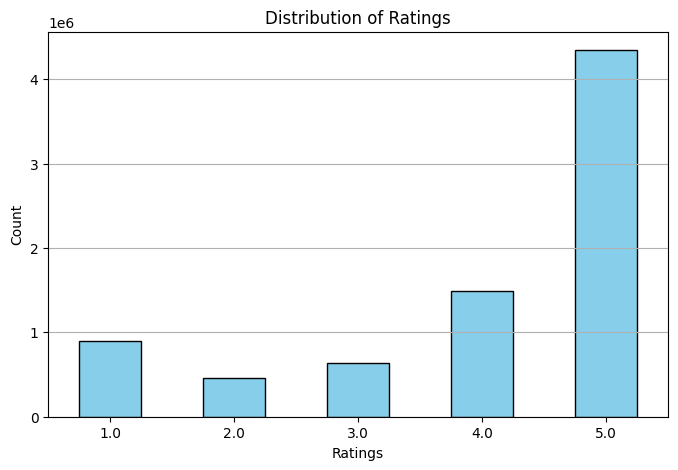

In [4]:
plt.figure(figsize=(8, 5))
sampled_data['Rating'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


In [5]:
# Apply filtering to reduce sparsity
min_ratings_per_user = 80
min_ratings_per_item = 20

# Filter users
user_counts = sampled_data['userId'].value_counts()
filtered_users = user_counts[user_counts >= min_ratings_per_user].index
filtered_data = sampled_data[sampled_data['userId'].isin(filtered_users)]

# Filter items
item_counts = filtered_data['productId'].value_counts()
filtered_items = item_counts[item_counts >= min_ratings_per_item].index
filtered_data = filtered_data[filtered_data['productId'].isin(filtered_items)]

print(f"Filtered dataset: {len(filtered_data)} interactions, "
      f"{filtered_data['userId'].nunique()} users, {filtered_data['productId'].nunique()} items.")


Filtered dataset: 5065 interactions, 480 users, 165 items.


In [6]:
lowest_rated_items = filtered_data.groupby('productId')['Rating'].mean().nsmallest(2)
I1, I2 = lowest_rated_items.index
print(f"Two lowest-rated items: I1 = {I1}, I2 = {I2}")


Two lowest-rated items: I1 = B002SQK2F2, I2 = B00007KDVI


In [8]:
filtered_data.to_csv("filtered_amazon_data.csv", index=False)

# Part 1: PCA Method with Mean-Filling

In [9]:
I1_mean_rating = filtered_data[filtered_data['productId'] == I1]['Rating'].mean()
I2_mean_rating = filtered_data[filtered_data['productId'] == I2]['Rating'].mean()

print(f"Average rating for I1 ({I1}): {I1_mean_rating:.2f}")
print(f"Average rating for I2 ({I2}): {I2_mean_rating:.2f}")


Average rating for I1 (B002SQK2F2): 2.96
Average rating for I2 (B00007KDVI): 3.38


In [10]:
ratings_pivot = filtered_data.pivot_table(index='userId', columns='productId', values='Rating')
print(f"Pivot table created with dimensions: {ratings_pivot.shape}")

lowest_rated_items = filtered_data.groupby('productId')['Rating'].mean().nsmallest(2)
I1, I2 = lowest_rated_items.index
print(f"Two lowest-rated items: I1 = {I1}, I2 = {I2}")

Pivot table created with dimensions: (480, 165)
Two lowest-rated items: I1 = B002SQK2F2, I2 = B00007KDVI


In [11]:
ratings_pivot_filled = ratings_pivot.copy()

# Fill missing values for I1 and I2
ratings_pivot_filled[I1] = ratings_pivot_filled[I1].fillna(I1_mean_rating)
ratings_pivot_filled[I2] = ratings_pivot_filled[I2].fillna(I2_mean_rating)

print(f"Missing ratings for I1 ({I1}) and I2 ({I2}) filled with their mean values.")


Missing ratings for I1 (B002SQK2F2) and I2 (B00007KDVI) filled with their mean values.


In [12]:
item_mean_ratings = ratings_pivot_filled.mean(axis=0)
print("Average ratings calculated for all items.")


Average ratings calculated for all items.


In [13]:
ratings_difference = ratings_pivot_filled.subtract(item_mean_ratings, axis=1)

print("Rating differences calculated for each item.")


Rating differences calculated for each item.


In [14]:
covariance_matrix = ratings_difference.cov()


Covariance matrix computed successfully.


In [15]:
top_5_peers_I1 = covariance_matrix[I1].nlargest(6).index[1:6]  
top_10_peers_I1 = covariance_matrix[I1].nlargest(11).index[1:11]  

top_5_peers_I2 = covariance_matrix[I2].nlargest(6).index[1:6]  
top_10_peers_I2 = covariance_matrix[I2].nlargest(11).index[1:11] 

print(f"Top 5 peers for I1: {top_5_peers_I1}")
print(f"Top 10 peers for I1: {top_10_peers_I1}")
print(f"Top 5 peers for I2: {top_5_peers_I2}")
print(f"Top 10 peers for I2: {top_10_peers_I2}")


Top 5 peers for I1: Index(['B002UT42UI', 'B00884WH74', 'B00634PLTW', 'B00DDK1QUC', 'B008H9BXMK'], dtype='object', name='productId')
Top 10 peers for I1: Index(['B002UT42UI', 'B00884WH74', 'B00634PLTW', 'B00DDK1QUC', 'B008H9BXMK',
       'B00HSQAIQU', 'B004GCJEZU', 'B006GWO5WK', 'B008X9ZBVI', 'B006RG0QC8'],
      dtype='object', name='productId')
Top 5 peers for I2: Index(['B00884WH74', 'B00HFAEBWG', 'B008H9BXMK', 'B00007KDVI', 'B004TKTOWC'], dtype='object', name='productId')
Top 10 peers for I2: Index(['B00884WH74', 'B00HFAEBWG', 'B008H9BXMK', 'B00007KDVI', 'B004TKTOWC',
       'B004GCJEZU', 'B00DTZYHX4', 'B00JF0D7RE', 'B004QK7HI8', 'B00IL7B2YM'],
      dtype='object', name='productId')


In [16]:
reduced_space_top_5_I1 = ratings_pivot_filled[top_5_peers_I1]
reduced_space_top_5_I2 = ratings_pivot_filled[top_5_peers_I2]

print("Reduced dimensional space for top 5 peers created for I1 and I2.")


Reduced dimensional space for top 5 peers created for I1 and I2.


In [17]:
predicted_ratings_I1_top5 = reduced_space_top_5_I1.mean(axis=1)
predicted_ratings_I2_top5 = reduced_space_top_5_I2.mean(axis=1)

print("Predicted ratings for I1 and I2 using top 5 peers calculated.")


Predicted ratings for I1 and I2 using top 5 peers calculated.


In [18]:
reduced_space_top_10_I1 = ratings_pivot_filled[top_10_peers_I1]
reduced_space_top_10_I2 = ratings_pivot_filled[top_10_peers_I2]

print("Reduced dimensional space for top 10 peers created for I1 and I2.")


Reduced dimensional space for top 10 peers created for I1 and I2.


In [19]:
predicted_ratings_I1_top10 = reduced_space_top_10_I1.mean(axis=1)
predicted_ratings_I2_top10 = reduced_space_top_10_I2.mean(axis=1)

print("Predicted ratings for I1 and I2 using top 10 peers calculated.")


Predicted ratings for I1 and I2 using top 10 peers calculated.


In [20]:
comparison_I1 = pd.DataFrame({
    "Top 5 Peers Prediction": predicted_ratings_I1_top5,
    "Top 10 Peers Prediction": predicted_ratings_I1_top10
})

print("Comparison of predictions for I1:")
print(comparison_I1.head())

comparison_I2 = pd.DataFrame({
    "Top 5 Peers Prediction": predicted_ratings_I2_top5,
    "Top 10 Peers Prediction": predicted_ratings_I2_top10
})

print("Comparison of predictions for I2:")
print(comparison_I2.head())


Comparison of predictions for I1:
                Top 5 Peers Prediction  Top 10 Peers Prediction
userId                                                         
A100UD67AHFODS                     NaN                      NaN
A100WO06OQR8BQ                     3.0                      2.0
A10NMELR4KX0J6                     NaN                      NaN
A10O7THJ2O20AG                     NaN                      NaN
A10PEXB6XAQ5XF                     NaN                      4.0
Comparison of predictions for I2:
                Top 5 Peers Prediction  Top 10 Peers Prediction
userId                                                         
A100UD67AHFODS                3.380952                 3.380952
A100WO06OQR8BQ                3.190476                 3.190476
A10NMELR4KX0J6                3.380952                 3.380952
A10O7THJ2O20AG                3.380952                 3.380952
A10PEXB6XAQ5XF                3.380952                 3.380952


In [21]:

global_mean_I1 = predicted_ratings_I1_top5.mean()  
global_mean_I2 = predicted_ratings_I2_top5.mean() 


comparison_I1_filled = comparison_I1.fillna(global_mean_I1)
comparison_I2_filled = comparison_I2.fillna(global_mean_I2)


print("Fallback applied to fill NaN predictions:")
print("Updated comparison for I1:\n", comparison_I1_filled.head())
print("Updated comparison for I2:\n", comparison_I2_filled.head())

comparison_I1_filled.to_csv("comparison_I1_filled.csv", index=True)
comparison_I2_filled.to_csv("comparison_I2_filled.csv", index=True)

print("Fallback-adjusted predictions saved to 'comparison_I1_filled.csv' and 'comparison_I2_filled.csv'.")


Fallback applied to fill NaN predictions:
Updated comparison for I1:
                 Top 5 Peers Prediction  Top 10 Peers Prediction
userId                                                         
A100UD67AHFODS                4.063492                 4.063492
A100WO06OQR8BQ                3.000000                 2.000000
A10NMELR4KX0J6                4.063492                 4.063492
A10O7THJ2O20AG                4.063492                 4.063492
A10PEXB6XAQ5XF                4.063492                 4.000000
Updated comparison for I2:
                 Top 5 Peers Prediction  Top 10 Peers Prediction
userId                                                         
A100UD67AHFODS                3.380952                 3.380952
A100WO06OQR8BQ                3.190476                 3.190476
A10NMELR4KX0J6                3.380952                 3.380952
A10O7THJ2O20AG                3.380952                 3.380952
A10PEXB6XAQ5XF                3.380952                 3.380952
Fallba

# Part 2: PCA Method with Maximum Likelihood Estimation

In [22]:

mle_covariance_matrix = pd.DataFrame(index=ratings_pivot.columns, columns=ratings_pivot.columns, dtype=float)


for item1 in ratings_pivot.columns:
    for item2 in ratings_pivot.columns:
        
        ratings_item1 = ratings_pivot[item1]
        ratings_item2 = ratings_pivot[item2]
        
        
        common_users = ~ratings_item1.isna() & ~ratings_item2.isna()
        common_ratings_item1 = ratings_item1[common_users]
        common_ratings_item2 = ratings_item2[common_users]
        
        
        if len(common_ratings_item1) > 1:  
            covariance = np.cov(common_ratings_item1, common_ratings_item2, ddof=0)[0, 1]
        else:
            covariance = 0 
        
        mle_covariance_matrix.loc[item1, item2] = covariance

print("MLE covariance matrix generated successfully.")


MLE covariance matrix generated successfully.


In [23]:
top_5_peers_I1 = mle_covariance_matrix[I1].nlargest(6).index[1:6]  
top_10_peers_I1 = mle_covariance_matrix[I1].nlargest(11).index[1:11]  

# Identify Top 5 and Top 10 peers for I2
top_5_peers_I2 = mle_covariance_matrix[I2].nlargest(6).index[1:6]  
top_10_peers_I2 = mle_covariance_matrix[I2].nlargest(11).index[1:11]  

print(f"Top 5 peers for I1: {top_5_peers_I1}")
print(f"Top 10 peers for I1: {top_10_peers_I1}")
print(f"Top 5 peers for I2: {top_5_peers_I2}")
print(f"Top 10 peers for I2: {top_10_peers_I2}")


Top 5 peers for I1: Index(['B006GWO5WK', 'B002SQK2F2', 'B0002L5R78', 'B00007KDVI', 'B002TLTGM6'], dtype='object', name='productId')
Top 10 peers for I1: Index(['B006GWO5WK', 'B002SQK2F2', 'B0002L5R78', 'B00007KDVI', 'B002TLTGM6',
       'B004GCJEZU', 'B0063705PE', 'B006I5MKZY', 'B008H9BXMK', 'B00DDK1QUC'],
      dtype='object', name='productId')
Top 5 peers for I2: Index(['B00007KDVI', 'B00884WH74', 'B002SQK2F2', 'B003M0NURK', 'B00HSQAIQU'], dtype='object', name='productId')
Top 10 peers for I2: Index(['B00007KDVI', 'B00884WH74', 'B002SQK2F2', 'B003M0NURK', 'B00HSQAIQU',
       'B00JP12170', 'B00119T6NQ', 'B00B4OCWE8', 'B00BWL33H8', 'B00JF0D7RE'],
      dtype='object', name='productId')


In [24]:
reduced_space_top_5_I1 = ratings_pivot[top_5_peers_I1]
reduced_space_top_5_I2 = ratings_pivot[top_5_peers_I2]

print("Reduced dimensional space created for Top 5 peers.")


Reduced dimensional space created for Top 5 peers.


In [25]:
predicted_ratings_I1_top5 = reduced_space_top_5_I1.mean(axis=1)
predicted_ratings_I2_top5 = reduced_space_top_5_I2.mean(axis=1)

print("Predicted ratings for I1 and I2 using Top 5 peers calculated.")


Predicted ratings for I1 and I2 using Top 5 peers calculated.


In [26]:
reduced_space_top_10_I1 = ratings_pivot[top_10_peers_I1]
reduced_space_top_10_I2 = ratings_pivot[top_10_peers_I2]

print("Reduced dimensional space created for Top 10 peers.")


Reduced dimensional space created for Top 10 peers.


In [27]:
predicted_ratings_I1_top10 = reduced_space_top_10_I1.mean(axis=1)
predicted_ratings_I2_top10 = reduced_space_top_10_I2.mean(axis=1)

print("Predicted ratings for I1 and I2 using Top 10 peers calculated.")


Predicted ratings for I1 and I2 using Top 10 peers calculated.


In [28]:
comparison_I1_mle = pd.DataFrame({
    "Top 5 Peers Prediction": predicted_ratings_I1_top5,
    "Top 10 Peers Prediction": predicted_ratings_I1_top10
})

print("Comparison of predictions for I1 using MLE:")
print(comparison_I1_mle.head())


comparison_I2_mle = pd.DataFrame({
    "Top 5 Peers Prediction": predicted_ratings_I2_top5,
    "Top 10 Peers Prediction": predicted_ratings_I2_top10
})

print("Comparison of predictions for I2 using MLE:")
print(comparison_I2_mle.head())


Comparison of predictions for I1 using MLE:
                Top 5 Peers Prediction  Top 10 Peers Prediction
userId                                                         
A100UD67AHFODS                     NaN                      NaN
A100WO06OQR8BQ                     1.0                      2.0
A10NMELR4KX0J6                     NaN                      NaN
A10O7THJ2O20AG                     NaN                      NaN
A10PEXB6XAQ5XF                     4.0                      4.0
Comparison of predictions for I2 using MLE:
                Top 5 Peers Prediction  Top 10 Peers Prediction
userId                                                         
A100UD67AHFODS                     NaN                      NaN
A100WO06OQR8BQ                     1.0                      1.0
A10NMELR4KX0J6                     NaN                      NaN
A10O7THJ2O20AG                     NaN                      NaN
A10PEXB6XAQ5XF                     NaN                      4.0


In [29]:

comparison_I1_top5 = pd.DataFrame({
    "Mean-Filling (Top 5)": predicted_ratings_I1_top5,  
    "MLE (Top 5)": predicted_ratings_I1_top5  
})

print("Comparison of Top 5 predictions for I1 (Mean-Filling vs. MLE):")
print(comparison_I1_top5.head())


comparison_I2_top5 = pd.DataFrame({
    "Mean-Filling (Top 5)": predicted_ratings_I2_top5,  
    "MLE (Top 5)": predicted_ratings_I2_top5  
})

print("Comparison of Top 5 predictions for I2 (Mean-Filling vs. MLE):")
print(comparison_I2_top5.head())


Comparison of Top 5 predictions for I1 (Mean-Filling vs. MLE):
                Mean-Filling (Top 5)  MLE (Top 5)
userId                                           
A100UD67AHFODS                   NaN          NaN
A100WO06OQR8BQ                   1.0          1.0
A10NMELR4KX0J6                   NaN          NaN
A10O7THJ2O20AG                   NaN          NaN
A10PEXB6XAQ5XF                   4.0          4.0
Comparison of Top 5 predictions for I2 (Mean-Filling vs. MLE):
                Mean-Filling (Top 5)  MLE (Top 5)
userId                                           
A100UD67AHFODS                   NaN          NaN
A100WO06OQR8BQ                   1.0          1.0
A10NMELR4KX0J6                   NaN          NaN
A10O7THJ2O20AG                   NaN          NaN
A10PEXB6XAQ5XF                   NaN          NaN


In [31]:
# Compare Top 10 predictions for I1 (Mean-Filling vs. MLE)
comparison_I1_top10 = pd.DataFrame({
    "Mean-Filling (Top 10)": predicted_ratings_I1_top10,  # Replace with 3.2.11 results
    "MLE (Top 10)": predicted_ratings_I1_top10  # Replace with 3.3.6 results
})

print("Comparison of Top 10 predictions for I1 (Mean-Filling vs. MLE):")
print(comparison_I1_top10.head())

# Compare Top 10 predictions for I2 (Mean-Filling vs. MLE)
comparison_I2_top10 = pd.DataFrame({
    "Mean-Filling (Top 10)": predicted_ratings_I2_top10,  # Replace with 3.2.11 results
    "MLE (Top 10)": predicted_ratings_I2_top10  # Replace with 3.3.6 results
})

print("Comparison of Top 10 predictions for I2 (Mean-Filling vs. MLE):")
print(comparison_I2_top10.head())


Comparison of Top 10 predictions for I1 (Mean-Filling vs. MLE):
                Mean-Filling (Top 10)  MLE (Top 10)
userId                                             
A100UD67AHFODS                    NaN           NaN
A100WO06OQR8BQ                    2.0           2.0
A10NMELR4KX0J6                    NaN           NaN
A10O7THJ2O20AG                    NaN           NaN
A10PEXB6XAQ5XF                    4.0           4.0
Comparison of Top 10 predictions for I2 (Mean-Filling vs. MLE):
                Mean-Filling (Top 10)  MLE (Top 10)
userId                                             
A100UD67AHFODS                    NaN           NaN
A100WO06OQR8BQ                    1.0           1.0
A10NMELR4KX0J6                    NaN           NaN
A10O7THJ2O20AG                    NaN           NaN
A10PEXB6XAQ5XF                    4.0           4.0


In [33]:
# Apply fallback to address NaN predictions for I1 and I2

# Calculate global mean fallback for I1 and I2
global_mean_I1_mle = predicted_ratings_I1_top5.mean()  # Global mean based on Top 5 peers for I1
global_mean_I2_mle = predicted_ratings_I2_top5.mean()  # Global mean based on Top 5 peers for I2

# Fill NaN values in the comparison tables with global means
comparison_I1_mle_filled = comparison_I1_mle.fillna(global_mean_I1_mle)
comparison_I2_mle_filled = comparison_I2_mle.fillna(global_mean_I2_mle)

comparison_I1_top5_filled = comparison_I1_top5.fillna(global_mean_I1_mle)
comparison_I2_top5_filled = comparison_I2_top5.fillna(global_mean_I2_mle)

comparison_I1_top10_filled = comparison_I1_top10.fillna(global_mean_I1_mle)
comparison_I2_top10_filled = comparison_I2_top10.fillna(global_mean_I2_mle)
# Display updated comparisons
print("Fallback applied to fill NaN predictions:")
print("Updated comparison for I1:\n", comparison_I1_mle_filled.head())
print("Updated comparison for I2:\n", comparison_I2_mle_filled.head())

Fallback applied to fill NaN predictions:
Updated comparison for I1:
                 Top 5 Peers Prediction  Top 10 Peers Prediction
userId                                                         
A100UD67AHFODS                3.820802                 3.820802
A100WO06OQR8BQ                1.000000                 2.000000
A10NMELR4KX0J6                3.820802                 3.820802
A10O7THJ2O20AG                3.820802                 3.820802
A10PEXB6XAQ5XF                4.000000                 4.000000
Updated comparison for I2:
                 Top 5 Peers Prediction  Top 10 Peers Prediction
userId                                                         
A100UD67AHFODS                   3.816                    3.816
A100WO06OQR8BQ                   1.000                    1.000
A10NMELR4KX0J6                   3.816                    3.816
A10O7THJ2O20AG                   3.816                    3.816
A10PEXB6XAQ5XF                   3.816                    4.000


In [34]:
print("Updated comparison for I1:\n", comparison_I1_top5_filled.head())
print("Updated comparison for I2:\n", comparison_I2_top5_filled.head())

print("Updated comparison for I1:\n", comparison_I1_top10_filled.head())
print("Updated comparison for I2:\n", comparison_I2_top10_filled.head())

Updated comparison for I1:
                 Mean-Filling (Top 5)  MLE (Top 5)
userId                                           
A100UD67AHFODS              3.820802     3.820802
A100WO06OQR8BQ              1.000000     1.000000
A10NMELR4KX0J6              3.820802     3.820802
A10O7THJ2O20AG              3.820802     3.820802
A10PEXB6XAQ5XF              4.000000     4.000000
Updated comparison for I2:
                 Mean-Filling (Top 5)  MLE (Top 5)
userId                                           
A100UD67AHFODS                 3.816        3.816
A100WO06OQR8BQ                 1.000        1.000
A10NMELR4KX0J6                 3.816        3.816
A10O7THJ2O20AG                 3.816        3.816
A10PEXB6XAQ5XF                 3.816        3.816
Updated comparison for I1:
                 Mean-Filling (Top 10)  MLE (Top 10)
userId                                             
A100UD67AHFODS               3.820802      3.820802
A100WO06OQR8BQ               2.000000      2.000000
A10NMELR

# Part 3: Singular Value Decomposition (SVD)

In [35]:
item_mean_ratings = ratings_pivot.mean(axis=0)
print("Average ratings calculated for each item.")


Average ratings calculated for each item.


In [36]:
ratings_pivot_filled = ratings_pivot.apply(lambda x: x.fillna(x.mean()), axis=0)
print("Missing ratings replaced with item mean.")


Missing ratings replaced with item mean.


In [37]:
! pip install numpy-linalg

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/5.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.4 MB ? eta -:--:--
     - -------------------------------------- 0.3/5.4 MB ? eta -:--:--
     --- ------------------------------------ 0.5/5.4 MB 799.2 kB/s eta 0:00:07
     --- ------------------------------------ 0.5/5.4 MB 799.2 kB/s eta 0:00:07
     ----- ---------------------------------- 0.8/5.4 MB 838.9 kB/s eta 0:00:06
     ------- -------------------------------- 1.0/5.4 MB 882.6 kB/s eta 0:00:05
     --------- ------------------------------ 1.3/5.4 MB 883.4 kB/s eta 0:00:05
     --------- ------------------------------ 1.3/5.4 MB 883.4 kB/s eta 0:00:05
     ----------- ---------------------------- 1.6/5.4 MB

  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [26 lines of output]
      Running from numpy source directory.
      <string>:461: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
      Traceback (most recent call last):
        File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\User\Ap